In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")

In [7]:
eli5 = load_dataset("stanfordnlp/shp", data_dir="explainlikeimfive")

Found cached dataset json (/home/prasann/.cache/huggingface/datasets/stanfordnlp___json/stanfordnlp--shp-dc70a528e445ea5d/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
fulleli5 = load_dataset("eli5")

In [19]:
train = fulleli5['train_eli5']

In [20]:
questions = []
for i in range(len(train)):
    f = train[i]
    if f['selftext'] and len(f['selftext'])>10:
        questions.append(f['title']+f['selftext'])

In [25]:
edf = pd.DataFrame({'history':questions})

In [4]:
from src.utils.wordstats import *

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xxl", device_map="auto")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev
import numpy as np
from scipy.stats import spearmanr
from src.utils.analysis_utils import extract_scatter, get_traintest, hastok, aggregate_clusters

In [4]:
import pandas as pd

In [5]:
EBASE = "output/"
e = pd.read_json(EBASE+"bigdset.jsonl", orient="records", lines=True)

In [ ]:
e

In [5]:
def mean(l):
    if len(l)==0:
        #print("0 len?")
        return 0
    return sum(l)/len(l)

In [7]:
EBASE = "output/"
e = pd.read_json(EBASE+"testbigdset.jsonl", orient="records", lines=True)

(array([ 3.,  6., 13., 17., 34., 32., 44., 30., 14.,  5.]),
 array([0.34846225, 0.40811596, 0.46776967, 0.52742338, 0.58707709,
        0.6467308 , 0.70638451, 0.76603822, 0.82569193, 0.88534564,
        0.94499935]),
 <BarContainer object of 10 artists>)

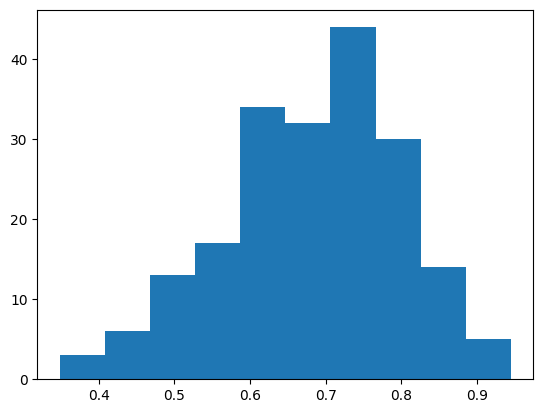

In [8]:
firsts = e[e['ver']=="first"].reset_index()
def random_base(fdf):
    values = []
    for i in range(len(fdf)):
        values.append(mean(fdf.iloc[i]['scos']))
    return values

plt.hist(random_base(firsts))

In [46]:
def mean_nidf(idict, text):
    words = re.findall(r'\w+', text.lower())
    fwords = []
    for w in words:
        if w in idict.keys():
            fwords.append(w)
    return mean([idict[w] for w in fwords])

In [26]:
resdf['meanimps'] = resdf['means']-resdf['initsco']

In [15]:
from src.utils.analysis_utils import get_phrase_prefix_strings, get_content_prefix_strings

In [ ]:
resdf  = extract_scatter(e, "rand")
#resdf['selstrs']= resdf.apply(lambda row: [tokenizer.decode(t) for t in tokenizer(row['selstrs'][0]).input_ids], axis=1)

In [62]:
resdf['inpstrs'].loc[100]


['We',
 'tend',
 'to',
 'play',
 '',
 'a',
 'song',
 'that',
 'we',
 'like',
 'over',
 'and',
 'over',
 'again',
 'to',
 'learn',
 'it',
 ',',
 'and',
 'when',
 'we',
 'find',
 'it',
 'boring',
 'we',
 'stop',
 'listening',
 'to',
 'it',
 '.',
 '</s>']

In [41]:
aclusts = aggregate_clusters(resdf, "improves", .1)

In [35]:
aclusts

,scomean,startind,endind,groupid,initsco,inpstrs,phraseprefs,contprefs
0,0.320706,2.0,2.0,(Explain like I'm five years old) Why does wat...,0.570727,"[When, water, is, frozen, into, , ice, ,, the,...",[11],[]
1,0.034333,5.0,5.0,(Explain like I'm five years old) Why does wat...,0.570727,"[When, water, is, frozen, into, , ice, ,, the,...",[11],[]
2,0.257268,8.0,14.0,(Explain like I'm five years old) Why does wat...,0.570727,"[When, water, is, frozen, into, , ice, ,, the,...",[11],[]
3,0.109184,17.0,17.0,(Explain like I'm five years old) Why does wat...,0.570727,"[When, water, is, frozen, into, , ice, ,, the,...",[11],[]
4,0.172216,20.0,20.0,(Explain like I'm five years old) Why does wat...,0.570727,"[When, water, is, frozen, into, , ice, ,, the,...",[11],[]
...,...,...,...,...,...,...,...,...
1608,0.008262,101.0,116.0,eli5: Why were laugh tracks so widely used on ...,0.892014,"[I, ', m, , re, watch, ing, some, older, sit, ...","[6, 15, 16, 23, 46, 52, 60, 63, 76, 90, 116, 1...",[]
1609,0.019245,119.0,134.0,eli5: Why were laugh tracks so widely used on ...,0.892014,"[I, ', m, , re, watch, ing, some, older, sit, ...","[6, 15, 16, 23, 46, 52, 60, 63, 76, 90, 116, 1...",[]
1610,0.022926,137.0,152.0,eli5: Why were laugh tracks so widely used on ...,0.892014,"[I, ', m, , re, watch, ing, some, older, sit, ...","[6, 15, 16, 23, 46, 52, 60, 63, 76, 90, 116, 1...",[]
1611,0.001756,155.0,170.0,eli5: Why were laugh tracks so widely used on ...,0.892014,"[I, ', m, , re, watch, ing, some, older, sit, ...","[6, 15, 16, 23, 46, 52, 60, 63, 76, 90, 116, 1...",[]


In [42]:
def inbound(inparr, s, e):
    for i in inparr:
        if i>s-2 and i<e:
            return 1
    return 0

In [43]:
aclusts['hascomma'] = aclusts.apply(lambda row: hastok(row['inpstrs'], int(row['startind']), int(row['endind']), ","), axis=1)

In [44]:
aclusts['pbound'] = aclusts.apply(lambda row: inbound(row['phraseprefs'], int(row['startind']), int(row['endind'])), axis=1)
aclusts['cbound'] = aclusts.apply(lambda row: inbound(row['contprefs'], int(row['startind']), int(row['endind'])), axis=1)

In [45]:
metric = "pbound"
checkhyp = aclusts[aclusts['scomean']>0.1]
print(">.1 improvement")
print(sum(checkhyp[metric]), "/", len(checkhyp))
print(sum(checkhyp[metric])/len(checkhyp))
others = aclusts[aclusts['scomean']<=0.1]
print("less improvement")
print(sum(others[metric]), "/", len(others))
print(sum(others[metric])/len(others))

>.1 improvement
141 / 386
0.36528497409326427
less improvement
395 / 755
0.5231788079470199


(array([ 12.,  54., 104., 237., 378., 171.,  70.,  19.,   6.,   3.]),
 array([-0.38205799, -0.29393489, -0.20581178, -0.11768868, -0.02956558,
         0.05855752,  0.14668062,  0.23480372,  0.32292683,  0.41104993,
         0.49917303]),
 <BarContainer object of 10 artists>)

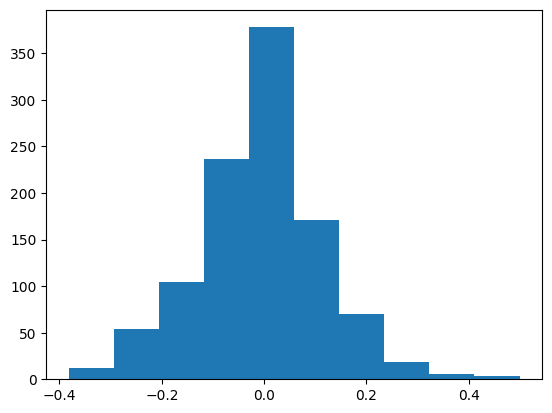

In [42]:
plt.hist(aclusts['scomean'])

In [122]:
sum(resdf['hascomma'])

740

In [179]:
resdf

,mean,stdev,entropy,skewness,kurtoses,top1s,selected,inpstrs,improves,initsco,prefpercent,prefix,selstrs,prompt,stdevs,means,hascomma
0,0.000031,0.003684,1.342,165.60,28620.0,0.6414,0.64140,"[Your, body, burn, s, calories, to, perform, b...",0.202028,0.558923,0.037736,2.0,[Your body burns calories by performing variou...,Explain like I'm five years old: How does your...,0.151311,0.579674,0
1,0.000031,0.001827,2.618,86.83,8553.0,0.2083,0.20830,"[Your, body, burn, s, calories, to, perform, b...",0.124418,0.558923,0.094340,5.0,[Your body burns calories to keep your organs ...,Explain like I'm five years old: How does your...,0.204442,0.514470,0
2,0.000031,0.004200,1.126,175.60,31240.0,0.7476,0.74760,"[Your, body, burn, s, calories, to, perform, b...",0.111265,0.558923,0.150943,8.0,[Your body burns calories to perform basic fun...,Explain like I'm five years old: How does your...,0.064833,0.614145,0
3,0.000031,0.005579,0.000,179.20,32120.0,1.0000,1.00000,"[Your, body, burn, s, calories, to, perform, b...",0.178249,0.558923,0.207547,11.0,[Your body burns calories to perform basic fun...,Explain like I'm five years old: How does your...,0.096091,0.659289,0
4,0.000031,0.003102,1.617,133.10,18800.0,0.4724,0.47240,"[Your, body, burn, s, calories, to, perform, b...",0.047225,0.558923,0.264151,14.0,[Your body burns calories to perform basic fun...,Explain like I'm five years old: How does your...,0.045609,0.570132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,0.000031,0.002731,1.944,132.80,19680.0,0.4295,0.16680,"[Farmers, use, the, , horn, s, of, male, bull,...",0.110497,0.621369,0.619048,26.0,[Farmers use the horns of male bulls to mate f...,Explain like I'm five years old: how do farmer...,0.106780,0.621121,0
3888,0.000031,0.001782,2.542,72.88,5746.0,0.1649,0.16490,"[Farmers, use, the, , horn, s, of, male, bull,...",0.055990,0.621369,0.690476,29.0,[Farmers use the horns of male bulls to mate f...,Explain like I'm five years old: how do farmer...,0.065218,0.619334,0
3889,0.000031,0.002103,2.399,106.00,13350.0,0.2973,0.11070,"[Farmers, use, the, , horn, s, of, male, bull,...",0.086492,0.621369,0.761905,32.0,[Farmers use the horns of male bulls to mate f...,Explain like I'm five years old: how do farmer...,0.038283,0.657454,0
3890,0.000031,0.003326,1.427,147.20,23370.0,0.5477,0.54770,"[Farmers, use, the, , horn, s, of, male, bull,...",0.059511,0.621369,0.833333,35.0,[Farmers use the horns of male bulls to mate f...,Explain like I'm five years old: how do farmer...,0.009105,0.669907,0


In [ ]:
aclusts = 

In [ ]:
plt.hist(resdf['prefpercent'])

Points  16
Explain like I'm five years old: Why is Blackjack the only mathematically beatable game in casino?
0.6371027231
FULL START
['Blackjack', 'is', 'considered', 'to', 'be', 'the', 'only', 'mathematical', 'ly', 'beat', 'able', 'game', 'in', '', 'a', 'casino']
PARTIAL START
['Blackjack', 'is', 'considered', 'to', 'be', 'the', 'only', 'mathematical', 'ly', 'beat', 'able', 'game', 'in', '', 'a', 'casino', ',', 'because', '', 'a', 'player', 'has', 'the', 'ability', 'to', 'count', 'cards', ',', 'and', 'be', '', 'able', 'to', 'use', 'their', 'skill', 'and', 'experience', 'to', 'successfully', 'predict', 'the', 'outcome', 'of', 'each', 'blackjack', 'hand']
49


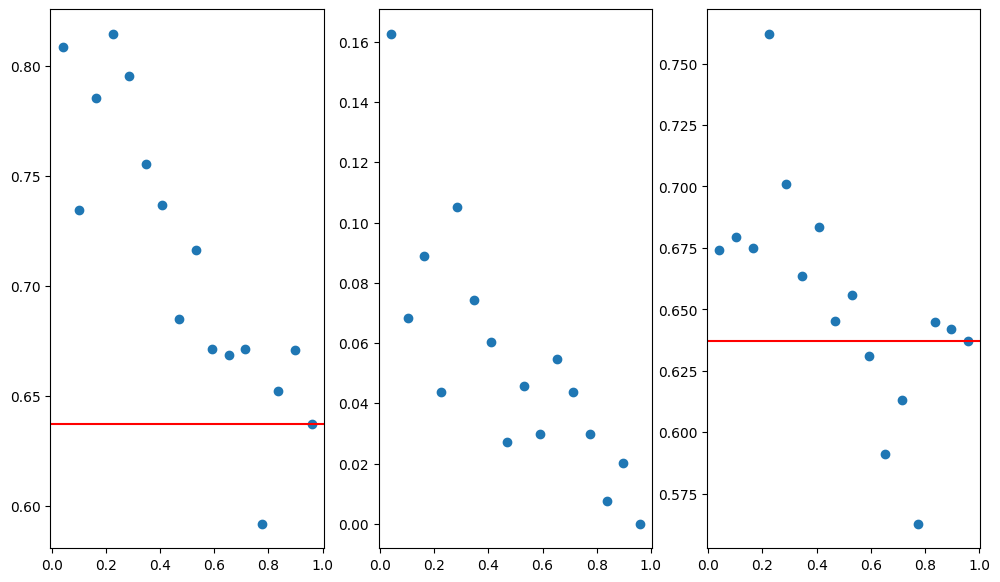

In [177]:
def plot_data(vind, cutoff):
    # all unique initial scores
    alluns = list(resdf['initsco'].unique())

    # get values at given spot
    subset = resdf[resdf['initsco']==alluns[vind]]
    ilen = len(subset)
    if cutoff == -1:
        cutoff = ilen
    print("Points ", ilen)

    # print prompt / SteamSHP
    print(subset['prompt'].iloc[0])
    print(alluns[vind])

    print("FULL START")
    print(subset['inpstrs'].iloc[0][:int(ilen*1)])
    print("PARTIAL START")
    print(subset['inpstrs'].iloc[0][:int(subset['prefix'].iloc[cutoff-1])])
    print(len(subset['inpstrs'].iloc[0]))
    fig, ax = plt.subplots(1, 3, figsize=(12, 7))
    ax[0].scatter(subset['prefpercent'].iloc[:cutoff], subset['improves'].iloc[:cutoff]+subset['initsco'].iloc[0])
    ax[0].axhline(y = subset['initsco'].iloc[0], color = 'r', linestyle = '-')
    ax[1].scatter(subset['prefpercent'].iloc[:cutoff], subset['stdevs'].iloc[:cutoff])
    ax[2].scatter(subset['prefpercent'].iloc[:cutoff], subset['means'].iloc[:cutoff])
    ax[2].axhline(y = subset['initsco'].iloc[0], color = 'r', linestyle = '-')

vi = 12

cut = -1
plot_data(vi, cut)

In [176]:
import spacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

In [ ]:
trainrdf, testrdf = get_traintest(resdf, 0.8)

In [ ]:
# write simple code, see if simple model does the trick
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
thresh = 0
def balance_labels(df):
    # Separate the DataFrame into two based on the condition
    above_zero_df = df[df['improves'] >= 0]
    below_zero_df = df[df['improves'] < 0]

    # Calculate the difference in lengths
    length_diff = len(above_zero_df) - len(below_zero_df)

    # Drop rows from the dominant class
    if length_diff > thresh:
        above_zero_df = above_zero_df.sample(len(below_zero_df))
    elif length_diff < thresh:
        below_zero_df = below_zero_df.sample(len(above_zero_df))

    # Concatenate the two balanced DataFrames
    return pd.concat([above_zero_df, below_zero_df], axis=0).reset_index(drop=True)


In [ ]:
btraindf = balance_labels(trainrdf)
btestdf = balance_labels(testrdf)

In [ ]:
X_train = btraindf.drop("improves", axis=1)
X_train = X_train.drop("inpstrs", axis=1)
y_train = btraindf['improves']
X_test = btestdf.drop("improves", axis=1)
X_test = X_test.drop("inpstrs", axis=1)
y_test = btestdf['improves']

In [ ]:
plt.hist(list([int(f) for f in y_test]))

In [ ]:
# Classification Setup
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your pandas DataFrame
# df = pd.read_csv('your_file.csv')
y_train = y_train > thresh
y_test = y_test > thresh

# List of models to try
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
]

# Evaluate the performance of each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("positive preds"+str(sum(y_pred)/len(y_pred)))
    print(f'{name}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print()

In [ ]:
# Hyperparameter tuning for RandomForestClassifier using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters for RandomForestClassifier: {best_params}")

# Train the model with the best hyperparameters and evaluate its performance
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Random Forest with best hyperparameters:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")

In [ ]:
# REGRESSION setup
# List of models to try
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
]

# Evaluate the performance of each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name}:')
    print(f'  Mean Squared Error: {mse:.4f}')
    print(f'  R2 Score: {r2:.4f}')
    print()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters to tune for GradientBoostingRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
}

# Perform grid search on GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='r2', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters and evaluate its performance
best_gbm = GradientBoostingRegressor(**best_params, random_state=42)
best_gbm.fit(X_train, y_train)
y_pred = best_gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Gradient Boosting with best hyperparameters:")
print(f"  Mean Squared Error: {mse:.4f}")
print(f"  R2 Score: {r2:.4f}")

In [ ]:
min_class_size = resdf['initsco'].value_counts().min()

# Group by class_id, sample the rows and concatenate the result
balanced = resdf.groupby('initsco').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


In [ ]:
resdf

In [ ]:
start = resdf[resdf['initsco']<0.85].reset_index()

In [ ]:
# get correlation histogram plots
smans = []
alluns = list(start['initsco'].unique())

for i in range(len(alluns)):
    subset = start[start['initsco']==alluns[i]]
    smans.append(spearmanr(subset['kurtoses'], subset['improves']).correlation)

In [ ]:
origs = e[e['ver']=="worst"]

In [ ]:
# get individual prefix scatters
smans = []
alluns = list(resdf['initsco'].unique())
vind = 5
subset = resdf[resdf['initsco']==alluns[vind]]
print(alluns[vind])
plt.scatter(subset['prefpercent'], subset['improves'])

In [ ]:
inits = e[e['ver']=='first']

In [ ]:
inits[inits['inpstr']=="Explain like I'm five years old: why do the fastest bicycles have really thin tyres but the fastest cars have very wide tyres"]

In [ ]:
origs.iloc[565]['hyps'][0]

In [ ]:
test = balanced[balanced['prefpercent']>0.3]

In [ ]:
spearmanr(test['entropy'], test['improves'])

In [ ]:
def make_impred_dset(edf):
    

In [ ]:
plt.hist(balanced['initsco'].unique())

In [ ]:
plt.hist(balanced['initsco'])

In [ ]:
plt.hist(tmp['initsco'])

In [ ]:
tmp = resdf[resdf['prefpercent']>0.9]
print(spearmanr(tmp['stat'], tmp['improves']))
plt.scatter(tmp['stat'],tmp['improves'])

In [6]:
BASE = "output/prefpreds/"
p0s = pd.read_json(BASE+"prefpreds0.jsonl",orient="records", lines=True)
p1s = pd.read_json(BASE+"prefpreds1.jsonl",orient="records", lines=True)
p2s = pd.read_json(BASE+"prefpreds2.jsonl",orient="records", lines=True)
p3s = pd.read_json(BASE+"prefpreds3.jsonl",orient="records", lines=True)
p4s = pd.read_json(BASE+"prefpreds4.jsonl",orient="records", lines=True)

ValueError: Expected object or value

In [ ]:
sdf7 = pd.read_json(BASE+"verbprefpreds0_0.7.jsonl",orient="records", lines=True)
sdf3 = pd.read_json(BASE+"verbprefpreds0_0.3.jsonl",orient="records", lines=True)

In [ ]:
def ascosdist(sdf):
    oscos = []
    nscos = []
    for i in range(len(sdf)):
        oscos.extend(sdf.iloc[i]['scos'][0])
        nscos.extend(sdf.iloc[i]['scos'][1])
    return oscos, nscos

In [ ]:
os, ns = ascosdist(sdf3)
fig, ax2 = plt.subplots(1,2)
ax2[0].hist(os)
ax2[1].hist(ns)


In [ ]:
def showind_box(ind, sdf, newind):
    plt.boxplot(sdf['stats'].iloc[ind][newind]['entropy'], vert=True, meanline=True)
    plt.show()

In [ ]:
def plot_lines(ind, sdf, newind, inax, metric='entropy'):
    row = sdf.iloc[ind]
    data = np.array(row['stats'][newind][metric])
    tokeddata = tokenizer(row['hyps'][newind], padding=True, truncation=True, return_tensors="pt").input_ids
    pinds = torch.sum(tokeddata==0, dim=1)
    linds = torch.sum(tokeddata>0, dim=1)
    print(linds)
    #print(data.shape)
    #print(tokeddata.shape)
    for i in range(4):
        # stats ignoring pad tokens
        if pinds[i]>0:
            ndata = data[:-int(pinds[i]), i]
        else:
            ndata = data[:, i]
        #print("de-padded data ", ndata.shape)
        s = linds[i]-len(ndata)#+pinds[i])
        #print("start ", s)
        #print("end ", linds[i])
        inax.plot(range(s, int(linds[i])), ndata , label=str(row['scos'][newind][i]))
    inax.legend()
    


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# "mean", "stdev", "entropy", "skewness", "kurtoses", "top1s", "selected"
ind = 5
metric = "selected"
plot_lines(ind, sdf7, 0, ax[0],metric )
plot_lines(ind, sdf7, 1, ax[1], metric)

In [ ]:
def preproc_metric(row, metric, newind):
    data = np.array(row['stats'][newind][metric])
    tokeddata = tokenizer(row['hyps'][newind], padding=True, truncation=True, return_tensors="pt").input_ids
    pinds = torch.sum(tokeddata==0, dim=1)
    linds = torch.sum(tokeddata>0, dim=1)
    #print(linds)
    starts = []
    ndatas = []
    for i in range(4):
        # stats ignoring pad tokens
        if pinds[i]>0:
            ndata = data[:-int(pinds[i]), i]
        else:
            ndata = data[:, i]
        #print("de-padded data ", ndata.shape)
        s = linds[i]-len(ndata)#+pinds[i])
        starts.append(s)
        ndatas.append(ndata)
    return starts, ndatas
    
def get_agg_stats(row, metric):
    _, origdatas = preproc_metric(row, metric, 0)
    prefixes, newdatas = preproc_metric(row, metric, 1)
    aggres = []
    o_pre_means = []
    o_post_means = []
    o_full_means = []
    n_post_means = []
    for i in range(0, 4):
        aggres.append({
            "opre":mean(origdatas[i][:prefixes[i]]),
            "opost":mean(origdatas[i][prefixes[i]:]),
            "ofull":mean(origdatas[i]),
            "shp":row['scos'][0][i]
        })
        aggres.append({
            "pfull":mean(newdatas[i]),
            "shp":row['scos'][1][i]
        })

    return aggres
    
def makedataset(sdf, metric):
    allrows = []
    for s in range(len(sdf)):
        allrows.extend(get_agg_stats(sdf.iloc[s], metric))
    return pd.DataFrame(allrows)

In [ ]:
entdset = makedataset(sdf7, "kurtoses")
predata = entdset[entdset['opre']>0]
fig, ax = plt.subplots(3, 2)
good = predata[predata['shp']>.8]
ax[0][0].hist(list(good['ofull']))
ax[1][0].hist(list(good['opre']))
ax[2][0].hist(list(good['opost']))
good = predata[predata['shp']<.8]
ax[0][1].hist(list(good['ofull']))
ax[1][1].hist(list(good['opre']))
ax[2][1].hist(list(good['opost']))

In [ ]:
row = sdf7.iloc[0]
print(len(row['stats'][0]['entropy']))
print(len(row['stats'][1]['entropy']))
tokeddata = tokenizer(row['hyps'][0], padding=True, truncation=True, return_tensors="pt").input_ids

In [ ]:
showind_box(0, statsdf3, 0)

In [ ]:
allps = pd.concat([p0s, p1s, p2s, p3s, p4s]).reset_index()

In [ ]:
allps['scos'].iloc[0]

In [ ]:
stdev(allps['scos'].iloc[0][0])

In [ ]:
def variance_changes(aps):
    origvars = []
    newvars = []
    for i in range(len(aps)):
        scovals = aps['scos'].iloc[i]
        origvars.append(stdev(scovals[0]))
        newvars.append(stdev(scovals[1]))
    return origvars, newvars

def ngram_changes(aps, n):
    origvars = []
    newvars = []
    for i in range(len(aps)):
        hyps = aps['hyps'].iloc[i]
        ongs = [len(get_unique_ngrams(h, tokenizer, n)) for h in hyps[0]]
        nngs = [len(get_unique_ngrams(h, tokenizer, n)) for h in hyps[1]]
        origvars.append(mean(ongs))
        newvars.append(mean(nngs))
    return origvars, newvars


# let's use this as our evaluation metric for diversity
def get_unique_ngrams(sentence, tok, n):
    uns = set()
    toks = tok(sentence).input_ids
    #print(toks)
    for i in range(len(toks)-n):
        tmp = ""
        for j in range(i, i+n):
            tmp = tmp+"_"+str(toks[j])
        uns.add(tmp)
    return uns

In [ ]:
ov, nv = variance_changes(sdf7)

In [ ]:
sdf7['varnew'] = nv

In [ ]:
sdf7[sdf7['varnew']>0.2]['scos'].iloc[1]

In [ ]:
plt.hist(nv)

In [ ]:
plt.hist(nv)

In [ ]:
p3 = pd.read_json(BASE+"prefpreds0_0.7.jsonl",orient="records", lines=True)

In [ ]:
print(p3['new_avg'].mean())
print(p3['old_avg'].mean())

In [ ]:
orig_ngrams, new_ngrams = ngram_changes(p3, 1)
print(mean(new_ngrams))
print(mean(orig_ngrams))
orig_ngrams, new_ngrams = ngram_changes(p3, 3)
print(mean(new_ngrams))
print(mean(orig_ngrams))

In [ ]:
ovs, nvs = variance_changes(p3)

In [ ]:
print(mean(ovs))
print(mean(nvs))

In [ ]:
plt.hist(orig_ngrams)

In [ ]:
diffdist = []
diffdist.extend(list(p0s['newmax']-p0s['oldmax']))
diffdist.extend(list(p1s['newmax']-p0s['oldmax']))
diffdist.extend(list(p2s['newmax']-p0s['oldmax']))
diffdist.extend(list(p3s['newmax']-p0s['oldmax']))
diffdist.extend(list(p4s['newmax']-p0s['oldmax']))


In [ ]:
plt.hist(diffdist)

In [ ]:
diffdist = []
diffdist.extend(list(p0s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p1s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p2s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p3s['new_avg']-p0s['old_avg']))
diffdist.extend(list(p4s['new_avg']-p0s['old_avg']))


In [ ]:
plt.hist(diffdist)